## Programming Lab #2
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that predict the likelihood a person has a stroke. The data include:
  
  - `age`: Patient age, numeric
  - `avg_glucose_level`: Blood sugar levels, numeric
  - `bmi`: Body mass index, numeric
  - `ever_married`: Ever married, dummy/character (Yes, No)
  - `gender`: Male, Female, or Other, character
  - `heart_disease`: Has heart disease, dummy
  - `hypertension`: Has hypertension, dummy
  - `id`: Study identification number
  - `Residence_type`: Type of residence, dummy/character (Urban, Rural)
  - `smoking_status`: Former, never, or current smoker, categorical
  - `work_type`: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (`Private`), Self-employed (`Self-employed`)
  - `stroke`: Suffered a stroke in the sample period
  
The data come in two files: `training_data.csv`, which you should use to build your models, and `testing_data.csv`, which you should use to test your models. The models must be trained on the training data and tested on the testing data, but providing both files allows you to experiment with your choices and iterate on model designs. If performance drops on the testing data, you know there's a problem.
  
You can use any of the tools presented in class: $k$ nearest neighbor, linear models, or decision trees. In principle, $k$ means clustering might also be helpful for looking for patterns in the data that the other methods might miss. Using canned versions of more advanced tools (boosting, bagging, random forests, neural networks, etc.) is deeply unsporting and thus not allowed. You can be creative about transforming variables, or combining decision trees with linear models or $k$NN. Try something interesting. Fail extravagantly. The goal is to work on an intellectually interesting question that is similar to the tasks that data scientists are called on to do every day.
  
We will compare the groups' models to see if there are common trends or significant differences, and also to declare **The Winners** on the basis of whichever team achieves the lowest $RMSE$ on the testing data. A simple linear model with some polynomials and dummy variables achieves an $R^2$ of .087 and a $RMSE$ of .206. 

In [11]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('./data/training_data.csv')
df_test = pd.read_csv('./data/testing_data.csv')

y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

In [12]:
## Linear Model
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#
dummies = pd.concat([ pd.get_dummies(X_train['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_train = pd.concat([continuous,dummies],axis=1)

X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

dummies = pd.concat([ pd.get_dummies(X_test['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_test = pd.concat([continuous,dummies],axis=1)

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   # R squared measure


R2:  0.08717964343843831
RMSE:  0.20599583849613765


C:\Users\prana\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_27532\3321111561.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cluster'] = kmeans_pipeline.predict(df)


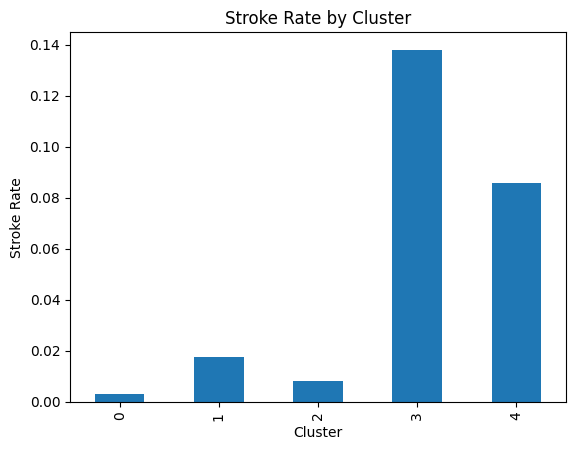

In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df_train = pd.read_csv('./data/training_data.csv')
df_test = pd.read_csv('./data/testing_data.csv')

# Split data into features and target
y_train = df_train['stroke']
X_train = df_train.drop('stroke', axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke', axis=1)

# Impute missing values for BMI
X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

# Select relevant columns for clustering
columns = ['avg_glucose_level', 'age', 'bmi', 'heart_disease', 'smoking_status']
df = X_train[columns]

# Preprocessing steps for clustering
numeric_features = ['avg_glucose_level', 'age', 'bmi']
numeric_transformer = StandardScaler()

categorical_features = ['heart_disease', 'smoking_status']
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# K-Means Clustering
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('kmeans', KMeans(n_clusters=5, random_state=0))])
kmeans_pipeline.fit(df)

# Assign clusters to the data
df.loc[:, 'cluster'] = kmeans_pipeline.predict(df)

# Merge cluster labels with original training data
df_train_with_clusters = df_train.assign(cluster=kmeans_pipeline.predict(df))

# Analyze clusters for stroke occurrence
cluster_stroke_analysis = df_train_with_clusters.groupby('cluster')['stroke'].agg(['mean', 'count']).rename(columns={'mean': 'Stroke Rate', 'count': 'Count'})

# Calculate overall stroke rate for comparison
overall_stroke_rate = df_train_with_clusters['stroke'].mean()

# Visualization
cluster_stroke_analysis['Stroke Rate'].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Stroke Rate')
plt.title('Stroke Rate by Cluster')
plt.show()


In [14]:
#Analyzing Clusters

# Calculate the mean values of numeric features within each cluster
numeric_features = ['avg_glucose_level', 'age', 'bmi']
cluster_numeric_characteristics = df_train_with_clusters.groupby('cluster')[numeric_features].mean()

print("Numeric Cluster Characteristics:\n", cluster_numeric_characteristics)


# Calculate the distribution of categorical features within each cluster
categorical_features = ['heart_disease', 'smoking_status']
for feature in categorical_features:
    print(f"Distribution of {feature} in each cluster:")
    distribution = df_train_with_clusters.groupby('cluster')[feature].value_counts(normalize=True).unstack()
    print(distribution, "\n")

Numeric Cluster Characteristics:
          avg_glucose_level        age        bmi
cluster                                         
0                93.236606   9.858265  20.297826
1                91.450761  42.525664  40.862301
2                91.109495  32.218018  26.475489
3               207.068601  60.353497  33.136192
4                89.451493  64.333605  28.428682
Distribution of heart_disease in each cluster:
heart_disease         0         1
cluster                          
0              0.998478  0.001522
1              0.982301  0.017699
2              0.998198  0.001802
3              0.839319  0.160681
4              0.893148  0.106852 

Distribution of smoking_status in each cluster:
smoking_status   Unknown  formerly smoked  never smoked    smokes
cluster                                                          
0               0.960426         0.015221      0.019787  0.004566
1               0.221239         0.201770      0.398230  0.178761
2               0.127928

In [15]:
# import pandas as pd
# import numpy as np
# df_train = pd.read_csv('./data/training_data.csv')
# df_test = pd.read_csv('./data/testing_data.csv')

# y_train = df_train['stroke']
# X_train = df_train.drop(['stroke','hypertension','work_type','Residence_type'],axis=1)
# y_test = df_test['stroke']
# X_test = df_test.drop(['stroke','hypertension','work_type','Residence_type'],axis=1)


# X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
# X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())



# ## Revised Linear Model
# from sklearn.linear_model import LinearRegression # Import linear regression model
# from sklearn.preprocessing import PolynomialFeatures

# X_train_numeric = X_train.loc[:,['age','heart_disease','avg_glucose_level', 'bmi'] ]
# #
# expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
# Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
# names = expander.get_feature_names_out() # Get the names of these variables
# continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
# #
# dummies = pd.concat([pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)
# #
# Z_train = pd.concat([continuous,dummies],axis=1)

# X_test_numeric = X_test.loc[:,['age','heart_disease','avg_glucose_level', 'bmi'] ]
# #
# expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
# Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
# names = expander.get_feature_names_out() # Get the names of these variables
# continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

# dummies = pd.concat([pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)],axis=1)

# #
# Z_test = pd.concat([continuous,dummies],axis=1)

# # Fit the model and get the R2 measure:
# reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
# print('R2: ', reg.score(Z_test, y_test)) # R squared measure
# y_hat = reg.predict(Z_test)
# N = len(y_test)
# print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   # R squared measure


In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Read data
df_train = pd.read_csv('./data/training_data.csv')
df_test = pd.read_csv('./data/testing_data.csv')

# Prepare data
y_train = df_train['stroke']
X_train = df_train.drop(['stroke', 'hypertension', 'work_type', 'Residence_type'], axis=1)
y_test = df_test['stroke']
X_test = df_test.drop(['stroke', 'hypertension', 'work_type', 'Residence_type'], axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

# Linear Model
numeric_features = ['age', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_features = ['smoking_status']

numeric_transformer = PolynomialFeatures(degree=2, include_bias=False)
categorical_transformer = OneHotEncoder(drop='first')

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

linear_model = make_pipeline(preprocessor_linear, LinearRegression())
linear_model.fit(X_train, y_train)

# Decision Tree Model
preprocessor_dt = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

dt_model = make_pipeline(preprocessor_dt, DecisionTreeRegressor(random_state=42))
dt_model.fit(X_train, y_train)

# Combine models using Stacking
estimators = [
    ('linear', linear_model),
    ('decision_tree', dt_model)
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)

# Make predictions and calculate RMSE and R-squared
y_hat_linear = stacking_model.named_estimators_['linear'].predict(X_test)
y_hat_dt = stacking_model.named_estimators_['decision_tree'].predict(X_test)
y_hat_stacking = stacking_model.predict(X_test)

rmse_linear = np.sqrt(mean_squared_error(y_test, y_hat_linear))
rmse_dt = np.sqrt(mean_squared_error(y_test, y_hat_dt))
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_hat_stacking))

r2_linear = r2_score(y_test, y_hat_linear)
r2_dt = r2_score(y_test, y_hat_dt)
r2_stacking = r2_score(y_test, y_hat_stacking)

print('Linear Model RMSE:', rmse_linear, 'R^2:', r2_linear)
print('Decision Tree Model RMSE:', rmse_dt, 'R^2:', r2_dt)
print('Stacking Model RMSE:', rmse_stacking, 'R^2:', r2_stacking)


Linear Model RMSE: 0.20574913810972614 R^2: 0.08936471951383473
Decision Tree Model RMSE: 0.29495596702371263 R^2: -0.8714696813977387
Stacking Model RMSE: 0.22576802811736074 R^2: -0.0964612867842658


This is supposed to be fairly "fun," so please do not turn it into a combinatorial nightmare of comparing thousands of model specifications. Settle on a strategy you think is promising, crank it out, and write up the results. Your time and energy are valuable, so learn to recognize when the marginal cost of another twenty minutes on a project exceeds the benefit in terms of improving the results and your grade.
  
## Paper format

The format of the paper should be:

  - Summary: A one paragraph description of the question, methods, and results (about 350 words).
  - Data: One to two pages discussing the data and key variables, and any challenges in reading, cleaning, and preparing them for analysis.
  - Results: Two to five pages providing visualizations, statistics, a discussion of your methodology, and a presentation of your main findings. 
  - Conclusion: One to two pages summarizing the project, defending it from criticism, and suggesting additional work that was outside the scope of the project.
  - Appendix: If you have a significant number of additional plots or table that you feel are essential to the project, you can put any amount of extra content at the end and reference it from the body of the paper. 

## Submission

Half of each student's grade is based on their commits to the repo. Each student is expected to do something specific that contributes to the overall project outcome. Since commits are recorded explicitly by Git/GitHub, this is observable. A student can contribute by cleaning data, creating visualizations,performing analytic analyses,  or writing about results, but everyone has to do something substantial. A student's work doesn't need to make it into the final report to be valuable and substantial, and fulfill the requirement to make a contribution to the project. 

The other half of each student's grade is based on the written report. Groups will work together on combining results and writing up findings in a Jupyter noteb,ok, using code chunks to execute Python commands and markdown chunks to structure the paper and provide exposition. The notebook should run on Colab or Rivana from beginning to end without any errors.

mbers submit.

## Criteria

The project is graded based on four criteria:

  - Project Concept: What is the strategy for building and testing the group's models? How did the group decide how to use the tools presented so far in class? How did the group compare the performance of the options considered, and settle on a final choice for submission?
  - Wrangling, EDA, and Visualization: How are are missing values handled? For variables with large numbers of missing values, to what extent do the data and documentation provide an explanation for the missing data? If multiple data sources are used, how are the data merged? For the main variables in the analysis, are the relevant data summarized and visualized through a histogram or kernel density plot where appropriate? Are basic quantitative features of the data addressed and explained? How are outliers characterized and addressed? 
  - Analysis: What are the groups' main findings? Do the tables, plots, and statistics support the conclusions? Is the research strategy carried out correctly? If the research strategy succeeds, are the results interpreted correctly and appropriately? If the research strategy fails, is a useful discussion of the flaws of the data collection process or the research strategy discussed?
  - Replication/Documentation: Is the code appropriately commented? Can the main results be replicated from the code and original data files? Are significant choices noted and explained?

Each of the four criteria are equally weighted (25 points out of 100).